In [1]:
# Contrôle de version
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

# Packages nécessaires
import numpy as np
import os
import re
import matplotlib.pyplot as plt
# A la première utilisation de nltk, télécharger les données nécessaires
import nltk
#nltk.download('punkt')

[//]: # (<span style="color:red">TODO</span> pour signaler du contenu manquant)

##  Word Embeddings : Représentations distribuées via l'hypothèse distributionelle

**But**: On va chercher à obtenir des représentations denses (comme vecteurs de nombres réels) de mots (et éventuellement de phrases). Ces représentations ont vocation à être distribuées: ce sont des représentations non-locales. On représente un objet comme une combinaison de *features*, par opposition à l'attribution d'un symbole dédié: voir le travail fondateur d'entre autres, Geoffrey Hinton, sur le sujet: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

Le terme de représentation *distribuées* est très général, mais correspond à que l'on cherche à obtenir. L'enjeu est donc de pouvoir construire, automatiquement, de telles représentations.

**Idée sous-jacente**: Elle est basée sur l'hypothèse distributionelle: les informations contextuelles suffisent à obtenir une représentation viable d'objets linguistiques.
 - *“For a large class of cases [...] the  meaning  of a word is  its  use in the  language.”* Wittgenstein (Philosophical Investigations, 43 - 1953)
 - *“You shall know a word by the company it keeps”*, Firth ("A synopsis of linguistic theory 1930-1955." - 1957)

Ainsi, on peut caractériser un mot par les mots qui l'accompagnent, via des comptes de co-occurences. Deux mots ayant un sens similaire auront une distribution contextuelle similaire et auront donc plus de chance d'apparaître dans des contextes similaires. Cette hypothèse peut servir de justification à l'application de statistiques à la sémantique (extraction d'information, analyse sémantique). Elle permet aussi une certaine forme de généralisation: on peut supposer que les informations que l'on a à propos d'un mot se généraliseront aux mots à la distribution similaire. 

**Motivation**: On cherche à obtenir des représentations distribuées pour pouvoir, de manière **efficace**:
- Directement réaliser une analyse sémantique de surface.
- S'en servir comme source d'informations pour d'autres modèles et applications liées au language, notamment pour l'analyse de sentiments. 


**Terminologie**: Attention à ne pas confondre l'idée de représentation *distribuée* et *distributionelle*. Le second indique en général (pour les mots) que la représentation a été obtenue strictement à partir de comptes de co-occurences, alors qu'on pourra utiliser des informations supplémentaires (labels de documents, tags de partie du discours, ...) pour construire des représentations distribuées. 
Les modèles qui permettent de construire ces représentations denses, sous forme de vecteurs, sont souvent appellés *vector spaces models*. On appelle aussi régulièrement ces représentations des *word embeddings*, car les mots sont embarqués (*embedded*) dans un espace vectoriel. En Français, on rencontre souvent le terme *plongements de mots* ou *plongements lexicaux*.

## Obtenir une représentation: comptes d'occurences et de co-occurences

Selon le type de corpus dont on dispose, on pourra obtenir différents types d'informations distributionelles. Si l'on a accès à une collection de documents, on pourra ainsi choisir de compter le nombre d'occurence de chaque mot dans chacun des documents, pour obtenir une matrice $mots \times documents$: c'est sur ce principe qu'est construit **Tf-Idf** (vu au TP précédent). On va maintenant s'intéresser à un cas plus général: on dispose d'une grande quantité de données sous forme de texte, et on cherche à obtenir des représentations de mots sous forme de vecteurs de taille réduite, sans avoir besoin d'un découpage en documents ou catégories. 

Supposons qu'on dispose d'un corpus contenant $T$ mots différents. On va construire une matrice $\mathbf{M}$ de taille $T \times T$ qui contiendra le nombre de co-occurences entre les mots. Il y aura différents facteurs à considérer lors de la construction de cette matrice: 
- Comment définir le 'contexte' d'un mot, qui permettra de dire que les termes qu'il contient co-occurent avec ce mot ? On pourra choisir d'utiliser différentes échelles: le document, la phrase, le groupe nominal, ou tout simplement une fenêtre de $k$ mots, selon les informations que l'on cherche à capturer.
*Encore une fois, si par exemple notre corpus est divisé en $D$ documents, on pourra même s'intéresser aux liens distributionnels entre mots et documents: chacun de ces $D$ documents agira comme un "contexte", et on construit une matrice d'occurences $\mathbf{M}$ de dimension $T \times D$, où $\mathbf{M}_{t,d}$ contient le nombre d'occurences du mot $t$ dans le document $d$.* 
- Comment quantifier l'importance des comptes ? Par exemple, on pourra donner un poids décroissant à une co-occurence selon la distance entre les deux mots concernés ($\frac{1}{d+1}$ pour une séparation par $d$ mots).
- Faut-il garder tous les mots qui apparaissent dans le corpus ? En général, non. On verra que pour les grands corpus, le nombre de mots différents $T$ est énorme. Deuxièmement, même si le nombre de mots est raisonnable, on ne possèdera que très peu d'information distributionelle sur les mots les plus rares, et la représentation obtenue sera à priori de mauvaise qualité. Il faudra se poser la question de comment filtrer ces mots, et de comment traiter les mots qu'on choisit de ne pas représenter.  

#### Procédure

Pour construire la matrice, on va dans un premier temps recueillir la liste des mots différents (ou le *vocabulaire* $V$) qui apparaissent dans le corpus sous forme de dictionaire {mots -> index}
Puis, pour chaque terme $w$ du corpus,
- On récupère l'index $i$ correspondant à l'aide de $V$
- Pour chaque terme $w'$ du contexte de $w$, 
  + On récupère l'index $j$ correspondant à l'aide de $V$
  + On incrémente $\mathbf{M}_{i,j}$ par le poids correspondant, ou par $1$. 
  
La procédure est très proche de celle qu'on a suivi au TP précédent, excepté qu'il faut maintenant compter les mots suivant leur apparition 
  
#### Exemple

On considère le corpus suivant: 

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

On choisit de définir le contexte d'un mot comme la phrase à laquelle il appartient, et de ne pas utiliser de poids. 
On obtient la matrice suivante: 

|     *         | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

In [2]:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

### Obtenir un Vocabulaire:

Cette fois, on va implémenter séparément une fonction retournant le vocabulaire. Il faudra ici pouvoir contrôler sa taille, que ce soit en indiquant un nombre maximum de mots, ou un nombre minimum d'occurences pour qu'on prenne en compte les mots. On ajoute, à la fin, un mot "inconnu" qui remplacera tous les mots qui n'apparaissent pas dans notre vocabulaire 'limité'. 

In [3]:
def vocabulary(corpus, count_threshold=1, voc_threshold=0):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency        
    """
    word_counts = {}
    for sent in corpus:
        for word in clean_and_tokenize(sent):
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1    
    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}        
    words = sorted(filtered_word_counts.keys(), key=word_counts.get, reverse=True)
    if voc_threshold > 0:
        words = words[:voc_threshold] + ['UNK']   
    vocabulary = {words[i] : i for i in range(len(words))}
    return vocabulary, {word: filtered_word_counts.get(word, 0) for word in vocabulary}

In [4]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'i': 2}
{'down': 6, 'the': 6, 'i': 5}
{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1}


### Obtenir les co-occurences:

La fonction prend en entrée le corpus (une liste de strings, correspondant aux documents, ou phrases) et un vocabulaire, ainsi que la taille de la fenêtre de contexte. On pourra aussi implémenter la solution la plus simple - que le contexte d'un mot soit le reste du document duquel il provient. 
Enfin, on pourra implémenter la possibilité de faire décroitre linéairement l'importance d'un mot du contexte à mesure qu'on s'éloigne du mot d'origine. 

In [5]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        sent = clean_and_tokenize(sent)
        # Notez l'utilisation de .get, qui permet de récupérer le mot associé (comme avec []) 
        # tout en renvoyant vers UNK (dernier token du vocabulaire) si le mot n'est pas dans le vocabulaire.
        sent_idx = [vocabulary.get(word, len(vocabulary)-1) for word in sent]
        for i, idx in enumerate(sent_idx):
            if idx > -1:
                if window > 0:
                    l_ctx_idx = [sent_idx[j] for j in range(max(0,i-window),i)]                
                else:
                    l_ctx_idx = sent_idx[:i]                
                for j, ctx_idx in enumerate(l_ctx_idx):
                    if ctx_idx > -1:
                        if distance_weighting:
                            weight = 1.0 / (len(l_ctx_idx) - j)
                        else:
                            weight = 1.0
                        M[idx, ctx_idx] += weight * 1.0
                        M[ctx_idx, idx] += weight * 1.0
    return M  

In [6]:
print(co_occurence_matrix(corpus, voc, 0, False))

[[2. 7. 6. 3. 3. 2. 2. 1. 1.]
 [7. 2. 6. 2. 2. 3. 3. 1. 1.]
 [6. 6. 0. 2. 2. 2. 2. 1. 1.]
 [3. 2. 2. 0. 1. 1. 0. 0. 0.]
 [3. 2. 2. 1. 0. 0. 0. 1. 0.]
 [2. 3. 2. 1. 0. 0. 1. 0. 0.]
 [2. 3. 2. 0. 0. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0.]]


In [7]:
from glob import glob
filenames_neg = sorted(glob(os.path.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(os.path.join('.', 'data', 'imdb1', 'pos', '*.txt')))

texts_neg = [open(f, encoding="utf8").read() for f in filenames_neg]
texts_pos = [open(f, encoding="utf8").read() for f in filenames_pos]
texts = texts_neg + texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

25000 documents


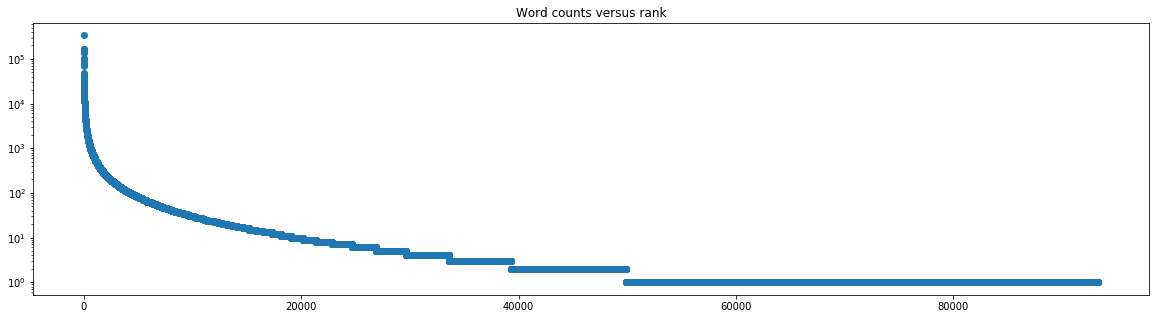

Vocabulary size: 93329
Part of the corpus by taking the "x" most frequent words:
5000 : 0.90
10000 : 0.94
15000 : 0.96
20000 : 0.97
25000 : 0.98
30000 : 0.98
35000 : 0.99
40000 : 0.99
45000 : 0.99
50000 : 0.99
55000 : 0.99
60000 : 0.99
65000 : 1.00
70000 : 1.00
75000 : 1.00
80000 : 1.00
85000 : 1.00
90000 : 1.00


In [8]:
corpus = texts

vocab, word_counts = vocabulary(corpus)
rank_counts = {w:[vocab[w], word_counts[w]] for w in vocab}
rank_counts_array = np.array(list(rank_counts.values()))

plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(rank_counts_array[:,0], rank_counts_array[:,1])
plt.yscale('log')
plt.show()

print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(5000, len(vocab), 5000):
    print('%i : %.2f' % (i, np.sum(rank_counts_array[:i, 1]) / np.sum(rank_counts_array[:,1]) ))

Résultat de l'analyse: on peut se contenter d'un vocabulaire de 10000, voire 5000 mots - c'est important, car cela va déterminer la taille des objets que l'on va manipuler. On va maintenant recréer la matrice de co-occurence avec différents paramètres. Cela peut-être long: si cela pose problème, travaillez avec un vocabulaire plus réduit.